In [2]:
# Common imports
import os
import sys
from tqdm import tqdm
import numpy as np
from pathlib import Path
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import yaml

# Torch imports
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Albumentations for data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Ultralytics YOLO for loading YOLOv11
!pip install ultralytics
from ultralytics import YOLO

In [4]:
#Define the Dataset Class for IP102
class IP102Dataset(Dataset):
    """A dataset class for the IP102 dataset in YOLO format."""

    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with images and labels (e.g., /kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train).
            transform (callable, optional): Optional data augmentation to be applied on a sample.
        """
        self.data_dir = Path(data_dir)
        self.image_list = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = str(self.data_dir / img_name)
        label_path = str(self.data_dir.parent.parent / 'labels' / self.data_dir.name / (img_name.replace('.jpg', '.txt')))

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Load labels
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                boxes = [list(map(float, line.strip().split())) for line in f.readlines()]
        else:
            boxes = []

        # Parse boxes
        bboxes = []
        labels = []
        for box in boxes:
            class_id, center_x, center_y, width, height = box
            # Convert YOLO format (normalized) to Pascal VOC format (absolute coordinates)
            img_height, img_width = img.shape[:2]
            xmin = (center_x - width / 2) * img_width
            ymin = (center_y - height / 2) * img_height
            xmax = (center_x + width / 2) * img_width
            ymax = (center_y + height / 2) * img_height
            bboxes.append([xmin, ymin, xmax, ymax])
            labels.append(int(class_id))

        if self.transform:
            transformed = self.transform(image=img, bboxes=bboxes, class_labels=labels)
            img = transformed["image"]
            bboxes = transformed["bboxes"]
            labels = transformed["class_labels"]

        if len(bboxes) > 0:
            bboxes = torch.tensor(bboxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.long)
        else:
            bboxes = torch.zeros((0, 4))
            labels = torch.zeros((0,), dtype=torch.long)

        return img, bboxes, labels

In [5]:
# Define Data Augmentation
transform = A.Compose([
    A.LongestMaxSize(416, p=1),
    A.PadIfNeeded(min_height=416, min_width=416, p=1, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_area=20))

/tmp/ipykernel_35/3553826755.py:4: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=416, min_width=416, p=1, border_mode=cv2.BORDER_CONSTANT, value=0),


In [6]:
# Set Up the Dataset and DataLoader
train_data_dir = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train"
val_data_dir = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/val"

train_dataset = IP102Dataset(train_data_dir, transform=transform)
val_dataset = IP102Dataset(val_data_dir, transform=transform)

def collate_fn(batch):
    images, bboxes, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, bboxes, labels

train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

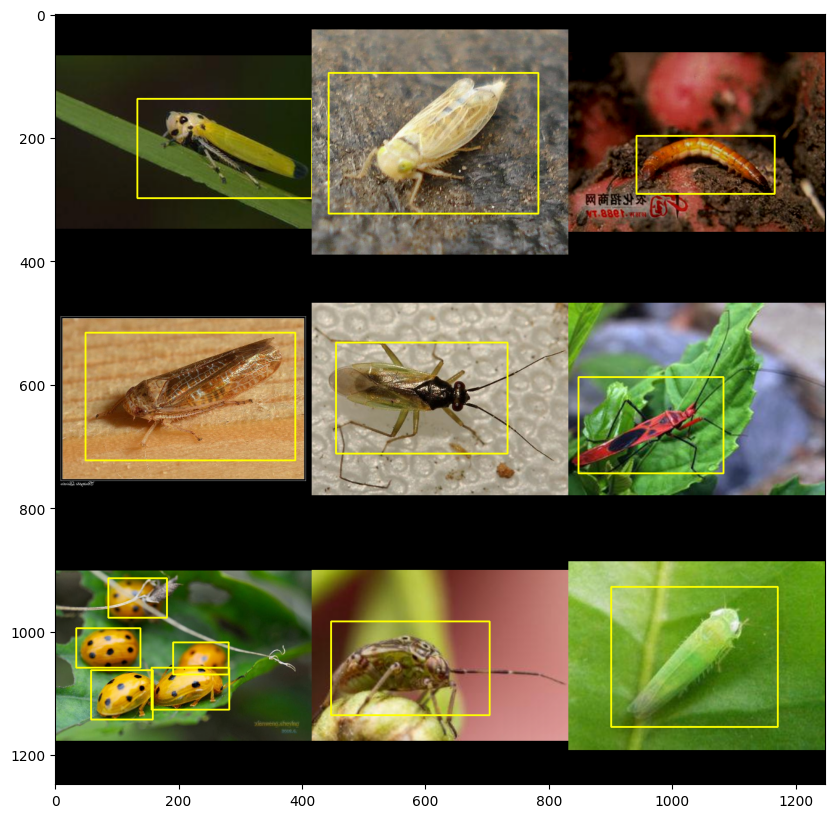

In [7]:
# Sanity Check of the Dataset
hlines = []
for i in range(3):
    vlines = []
    for j in range(3):
        idx = random.randint(0, len(train_dataset) - 1)
        img, bboxes, labels = train_dataset[idx]
        img = img.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = (img * 255).astype(np.uint8)

        for bbox in bboxes:
            x1, y1, x2, y2 = map(int, bbox)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 0), 2)

        vlines.append(img)
    hlines.append(cv2.vconcat(vlines))

final_img = cv2.hconcat(hlines)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(final_img)
plt.show()

In [8]:
# Load Pre-trained YOLOv8 Model
model = YOLO("/kaggle/input/yolov8/pytorch/default/1/yolov8l.pt")

# Copy the original ip102.yaml to the working directory and modify the paths
original_yaml_path = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/ip102.yaml"
new_yaml_path = "/kaggle/working/ip102_corrected.yaml"

# Read the original YAML file
with open(original_yaml_path, 'r') as f:
    yaml_content = yaml.safe_load(f)

# Update the paths to the correct absolute paths
yaml_content['train'] = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train"
yaml_content['val'] = "/kaggle/input/ip102-yolov5/IP102_YOLOv5/images/val"

# Save the modified YAML file
with open(new_yaml_path, 'w') as f:
    yaml.dump(yaml_content, f)

print(f"Modified ip102.yaml saved to {new_yaml_path}")
print("Updated paths:")
print(f"train: {yaml_content['train']}")
print(f"val: {yaml_content['val']}")

Modified ip102.yaml saved to /kaggle/working/ip102_corrected.yaml
Updated paths:
train: /kaggle/input/ip102-yolov5/IP102_YOLOv5/images/train
val: /kaggle/input/ip102-yolov5/IP102_YOLOv5/images/val


In [9]:
# Train the Model Using Ultralytics YOLO API
# The Ultralytics YOLO implementation simplifies training by handling the loss function and training loop internally.
# We just need to provide the dataset configuration and training parameters.

# Train the model
results = model.train(
    data=new_yaml_path,
    epochs=50,
    imgsz=416,
    batch=16,
    warmup_epochs=5,
    device=0,
    patience=15,
    save=True,
    project="/kaggle/working/yolo_training",
    name="ip102_yolov8l",
    cos_lr=True,
    lr0=0.001,
    augment=True,
    verbose=True
)

Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/ip102_corrected.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/yolov8/pytorch/default/1/yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ip102_yolov8l, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, p

100%|██████████| 755k/755k [00:00<00:00, 15.4MB/s]


Overriding model.yaml nc=80 with nc=102

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralyti

100%|██████████| 5.35M/5.35M [00:00<00:00, 124MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.2 ms, read: 8.7±5.0 MB/s, size: 63.4 KB)


train: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/train... 17646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17646/17646 [01:21<00:00, 215.36it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2.8±1.8 MB/s, size: 25.0 KB)


val: Scanning /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels/val... 1329 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1329/1329 [00:06<00:00, 208.38it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/ip102-yolov5/IP102_YOLOv5/labels is not writeable, cache not saved.
Plotting labels to /kaggle/working/yolo_training/ip102_yolov8l/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to /kaggle/working/yolo_training/ip102_yolov8l
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.42G      1.445      3.088      1.599         55        416: 100%|██████████| 1103/1103 [08:01<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:13<00:00,  3.15it/s]


                   all       1329       1621      0.579      0.325      0.318      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.89G      1.318      2.084      1.478         40        416: 100%|██████████| 1103/1103 [07:50<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]


                   all       1329       1621      0.472       0.36       0.34      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.92G       1.35      2.019      1.505         45        416: 100%|██████████| 1103/1103 [07:48<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]


                   all       1329       1621      0.583      0.343      0.349        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.95G      1.381      2.114      1.545         36        416: 100%|██████████| 1103/1103 [07:46<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]


                   all       1329       1621      0.534      0.339       0.32      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       7.9G      1.424      2.243       1.57         43        416: 100%|██████████| 1103/1103 [07:45<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]


                   all       1329       1621       0.52      0.307      0.296      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.91G      1.438      2.302      1.589         37        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]


                   all       1329       1621       0.59       0.28      0.303      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.94G       1.41      2.155      1.563         37        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


                   all       1329       1621      0.531      0.416      0.378      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.79G      1.378      2.023      1.545         47        416: 100%|██████████| 1103/1103 [07:45<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


                   all       1329       1621      0.475      0.427      0.394      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.75G      1.367      1.922      1.533         52        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]


                   all       1329       1621      0.581      0.429      0.427      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.73G       1.34      1.837      1.516         45        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]


                   all       1329       1621      0.568      0.461      0.452      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.57G      1.336        1.8      1.512         48        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]


                   all       1329       1621      0.488      0.518      0.474      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.73G       1.31      1.741      1.494         42        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]

                   all       1329       1621      0.504      0.542      0.486      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.72G      1.299      1.669      1.489         26        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]


                   all       1329       1621       0.41      0.614      0.518      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.73G      1.289      1.646      1.481         40        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]


                   all       1329       1621       0.48      0.591      0.546      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.57G      1.282      1.608      1.477         35        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


                   all       1329       1621      0.545      0.518      0.544      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.73G      1.274      1.571       1.47         35        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]


                   all       1329       1621       0.52      0.537      0.542      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.72G      1.262       1.53       1.46         40        416: 100%|██████████| 1103/1103 [07:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]


                   all       1329       1621      0.519      0.566      0.547       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.72G      1.254      1.492      1.453         37        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]


                   all       1329       1621      0.494      0.604      0.577      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.59G       1.24      1.464      1.445         32        416: 100%|██████████| 1103/1103 [07:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]

                   all       1329       1621      0.434      0.662      0.588      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.73G      1.236      1.427      1.442         39        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]


                   all       1329       1621      0.597      0.563      0.604      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.73G      1.217      1.396      1.429         36        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]


                   all       1329       1621      0.567      0.577      0.603      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.72G      1.217      1.371      1.427         38        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]


                   all       1329       1621      0.512      0.591      0.594      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.57G       1.21      1.351      1.421         48        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]

                   all       1329       1621      0.568        0.6      0.623      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.56G       1.19      1.314      1.412         34        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]


                   all       1329       1621      0.592      0.582      0.626      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.72G      1.184      1.295       1.41         43        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]


                   all       1329       1621      0.512      0.659      0.636      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.72G      1.181      1.257      1.404         38        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]


                   all       1329       1621      0.523      0.648      0.648      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.59G       1.17      1.242      1.399         40        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]


                   all       1329       1621      0.515      0.683       0.65      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.73G       1.16      1.224      1.392         36        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]


                   all       1329       1621      0.534      0.684      0.645      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.72G      1.152      1.197      1.384         42        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]


                   all       1329       1621      0.532      0.669      0.649      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.73G      1.135      1.167      1.379         72        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]


                   all       1329       1621      0.553      0.678      0.653      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.57G      1.132       1.14      1.371         43        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]


                   all       1329       1621       0.57      0.672      0.667      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.72G       1.12      1.112      1.365         35        416: 100%|██████████| 1103/1103 [07:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]


                   all       1329       1621      0.547       0.68      0.667      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.73G      1.109        1.1      1.361         47        416: 100%|██████████| 1103/1103 [07:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]


                   all       1329       1621       0.54      0.662      0.666      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.54G        1.1      1.076      1.354         39        416: 100%|██████████| 1103/1103 [07:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.48it/s]


                   all       1329       1621      0.526       0.69       0.67      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.57G      1.086      1.049      1.342         42        416: 100%|██████████| 1103/1103 [07:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]


                   all       1329       1621      0.589       0.66      0.681       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.73G      1.078      1.031       1.34         41        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]


                   all       1329       1621      0.559      0.668      0.682      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.71G      1.066      1.002      1.333         35        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]


                   all       1329       1621      0.594      0.664      0.677      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.53G      1.061     0.9933       1.33         42        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.43it/s]


                   all       1329       1621      0.628      0.628      0.671       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.57G      1.045      0.967      1.319         47        416: 100%|██████████| 1103/1103 [07:45<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]

                   all       1329       1621      0.602      0.645      0.666      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.73G      1.033     0.9467      1.311         34        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]

                   all       1329       1621      0.571       0.66      0.665      0.436


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.73G     0.9543     0.6628      1.368         15        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]


                   all       1329       1621       0.58      0.648      0.666      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.72G     0.9333     0.6321      1.351         15        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]

                   all       1329       1621      0.566      0.656      0.669      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.57G     0.9169     0.6118      1.344         14        416: 100%|██████████| 1103/1103 [07:45<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]

                   all       1329       1621      0.553      0.673      0.665       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.72G      0.902     0.5977       1.33         16        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]


                   all       1329       1621      0.536      0.704      0.661      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.72G     0.8909     0.5826      1.324         14        416: 100%|██████████| 1103/1103 [07:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]


                   all       1329       1621      0.542      0.692      0.662       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.73G     0.8795     0.5741      1.313         24        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.45it/s]


                   all       1329       1621       0.54      0.686       0.66      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.57G     0.8703     0.5609      1.307         19        416: 100%|██████████| 1103/1103 [07:44<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]


                   all       1329       1621      0.525      0.698      0.662      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.73G     0.8649     0.5557      1.303         40        416: 100%|██████████| 1103/1103 [07:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]


                   all       1329       1621      0.542      0.681      0.662      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.72G     0.8628      0.551      1.302         14        416: 100%|██████████| 1103/1103 [07:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.46it/s]


                   all       1329       1621       0.53      0.702      0.661      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.73G     0.8535     0.5462      1.293         14        416: 100%|██████████| 1103/1103 [07:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:12<00:00,  3.50it/s]


                   all       1329       1621       0.53      0.705       0.66      0.426

50 epochs completed in 6.646 hours.
Optimizer stripped from /kaggle/working/yolo_training/ip102_yolov8l/weights/last.pt, 87.8MB
Optimizer stripped from /kaggle/working/yolo_training/ip102_yolov8l/weights/best.pt, 87.8MB

Validating /kaggle/working/yolo_training/ip102_yolov8l/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 112 layers, 43,685,250 parameters, 0 gradients, 165.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1329       1621      0.568      0.684       0.68      0.438
      rice leaf roller         12         13      0.727          1      0.974      0.709
 rice leaf caterpillar          8          8      0.272      0.375      0.248      0.157
     paddy stem maggot          2          2       0.83          1      0.995      0.497
    asiatic rice borer         12         13      0.691      0.846      0.797      0.436
     yellow rice borer          6          6      0.842      0.833      0.931      0.563
       rice gall midge          7          7      0.787      0.857      0.964      0.456
          Rice Stemfly          2          2      0.341        0.5      0.662      0.207
    brown plant hopper          8          8      0.474        0.5      0.603      0.359
white backed plant hopper          5          5      0.613          1      0.928       0.59
small brown plant hopper          4          4       0.73        0.5      0.781      0.397
     rice water 